In [3]:
# For loading data and data manipulation
import pandas as pd
# For mathematical computations
import numpy as np
# For model building
from sklearn.cluster import KMeans
# For finding the optimal number of k
from sklearn.metrics import silhouette_score
# For evaluating performance of the model
from sklearn.metrics import davies_bouldin_score
from sklearn.metrics import calinski_harabasz_score
# For data visualization
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import mysql.connector as connection
warnings.filterwarnings('ignore')

# Load the data through MySQL

In [4]:
%%time
try:
    mydb = connection.connect(host="localhost", database = 'movie_series_rec',user="root", passwd="root",use_pure=True)
    movie_series_query = "select * from movie_series_data;"
    movie_series_df = pd.read_sql(movie_series_query, mydb)
    mv_srs_user_query = "select * from movie_series_userid;"
    mv_srs_user_df = pd.read_sql(mv_srs_user_query, mydb)
    mydb.close() #close the connection
except Exception as e:
    mydb.close()
    print(str(e))

CPU times: user 17.3 s, sys: 3.73 s, total: 21 s
Wall time: 22.2 s


In [5]:
%%time
movies_df = movie_series_df.loc[movie_series_df['TYPE'] == "movie"]
series_df = movie_series_df.loc[movie_series_df['TYPE'] == "series"]

CPU times: user 29.7 ms, sys: 12.3 ms, total: 42 ms
Wall time: 48.9 ms


In [6]:
# Top observation in movie dataset
movies_df.head()

,TITLE_ID,TITLE,IMDB_SCORE,TYPE,GENRE,POSTER,ACTORS,RATED,LANGUAGES,YEAR
0,1,Toy Story,8.3,movie,"Animation, Adventure, Comedy",https://m.media-amazon.com/images/M/MV5BMDU2ZW...,"Tom Hanks, Tim Allen, Don Rickles",G,English,1995
1,2,Jumanji,7.0,movie,"Adventure, Comedy, Family",https://m.media-amazon.com/images/M/MV5BZTk2Zm...,"Robin Williams, Kirsten Dunst, Bonnie Hunt",PG,"English, French",1995
2,3,Grumpier Old Men,6.6,movie,"Comedy, Romance",https://m.media-amazon.com/images/M/MV5BMjQxM2...,"Walter Matthau, Jack Lemmon, Ann-Margret",PG-13,"English, Italian, German",1995
3,4,Waiting to Exhale,5.9,movie,"Comedy, Drama, Romance",https://m.media-amazon.com/images/M/MV5BYzcyMD...,"Whitney Houston, Angela Bassett, Loretta Devine",R,English,1995
4,5,Father of the Bride Part II,6.0,movie,"Comedy, Family, Romance",https://m.media-amazon.com/images/M/MV5BOTEyNz...,"Steve Martin, Diane Keaton, Martin Short",PG,English,1995


In [7]:
# Top observation in movie_uid dataset
mv_srs_user_df.head() 

,USER_ID,TITLE_ID
0,1,307
1,1,481
2,1,1091
3,1,1257
4,1,1449


In [8]:
# Dimension of the datasets related to movies
print("Dimension of the movie dataset \n|", movies_df.shape)

Dimension of the movie dataset 
| (48423, 10)


In [9]:
# Top observation in series dataset
series_df.head()

,TITLE_ID,TITLE,IMDB_SCORE,TYPE,GENRE,POSTER,ACTORS,RATED,LANGUAGES,YEAR
48423,193889,Unforgettable,6.7,series,"Crime, Drama, Mystery",https://m.media-amazon.com/images/M/MV5BMTYwMz...,"Poppy Montgomery, Dylan Walsh, James Hiroyuki ...",TV-14,None,2011
48424,193890,Pie in the Sky,7.6,series,"Comedy, Crime, Drama",https://m.media-amazon.com/images/M/MV5BMTYzMD...,"Richard Griffiths, Maggie Steed, Malcolm Sinclair",Not Rated,English,1994
48425,193891,Reckless,7.0,series,"Crime, Drama",https://m.media-amazon.com/images/M/MV5BYjk0Zj...,"Kim Wayans, Michael Gladis, Gregory Harrison",None,English,2014
48426,193892,Hunted,7.3,series,"Action, Drama",https://m.media-amazon.com/images/M/MV5BMGFiMG...,"Melissa George, Adam Rayner, Patrick Malahide",TV-MA,"English, Arabic",2012
48427,193893,Little Princess,5.6,series,"Animation, Family",https://m.media-amazon.com/images/M/MV5BMjI5Nj...,"Jane Horrocks, Colin McFarlane, Julian Clary",TV-Y7,English,2006


In [10]:
# Dimension of the datasets
print("Dimension of the series dataset \n|", series_df.shape)

Dimension of the series dataset 
| (24791, 10)


In [11]:
movie_series_df.shape

(73214, 10)

In [12]:
#Removing Trailing Spaces from Movie/Series Titles
movie_series_df['TITLE'] = movie_series_df['TITLE'].str.strip()

In [13]:
# Check if the missing values has been removed
movie_series_df.isna().sum()

TITLE_ID          0
TITLE             0
IMDB_SCORE        0
TYPE              0
GENRE           262
POSTER         1390
ACTORS         1021
RATED         26540
LANGUAGES       925
YEAR              0
dtype: int64

In [14]:
movie_series_df[['RATED']] = movie_series_df[['RATED']].fillna(value='Unrated')
movie_series_df[['POSTER']] = movie_series_df[['POSTER']].fillna(value='Unavailable')
movie_series_df[['ACTORS']] = movie_series_df[['ACTORS']].fillna(value='Unknown')
movie_series_df.isna().sum()

TITLE_ID        0
TITLE           0
IMDB_SCORE      0
TYPE            0
GENRE         262
POSTER          0
ACTORS          0
RATED           0
LANGUAGES     925
YEAR            0
dtype: int64

In [15]:
# Delete missing values
movie_series_df.dropna(inplace= True)
movie_series_df.isna().sum()

TITLE_ID      0
TITLE         0
IMDB_SCORE    0
TYPE          0
GENRE         0
POSTER        0
ACTORS        0
RATED         0
LANGUAGES     0
YEAR          0
dtype: int64

In [16]:
# Duplicated values
print('Number of Duplicated values: \n{}'.format(movie_series_df.duplicated().sum()))
print('\nDuplicated values in Percentage: \n{}%'.format((movie_series_df.duplicated().sum()/len(movie_series_df)*100).round(2)))

Number of Duplicated values: 
5775

Duplicated values in Percentage: 
8.01%


In [17]:
# Drop the duplicated values as it is less than 10%
movie_series_df.drop_duplicates(inplace = True)
movie_series_df.shape

(66296, 10)

In [18]:
#Removing if there are duplicate TITLE_ID
movie_series_df = movie_series_df.drop_duplicates(subset=['TITLE_ID'], keep=False)
movie_series_df.shape

(63049, 10)

In [19]:
movie_series_df = movie_series_df.drop_duplicates(subset=['TITLE', 'TYPE', 'IMDB_SCORE'], keep=False)
movie_series_df.shape

(63049, 10)

# Standardize RATED Category

In [20]:
# Captalize RATED column 
movie_series_df['RATED'] = movie_series_df['RATED'].str.upper()

In [21]:
# Check for the unique values in Rated column
print(movie_series_df['RATED'].unique())
print("\nNumber of Unique Values =", movie_series_df['RATED'].nunique())

['G' 'PG' 'PG-13' 'R' 'PASSED' 'NOT RATED' 'UNRATED' 'TV-14' 'NC-17'
 'APPROVED' 'TV-MA' 'X' 'TV-PG' 'M/PG' 'GP' 'TV-Y7' 'M' 'TV-G' 'TV-Y7-FV'
 '16' 'OPEN' 'TV-13' 'TV-Y' 'E' 'S' 'AO' 'LIVRE' '15' '13' 'E10+' 'MA-17'
 '12']

Number of Unique Values = 32


In [22]:
movie_series_df[['RATED']] = movie_series_df[['RATED']].replace(dict.fromkeys(['OPEN', 'UNRATED', 'G', 'TV-G', 'LIVRE', 'E', 'BTL', 'S', 'K-3'], 'G'))
movie_series_df[['RATED']] = movie_series_df[['RATED']].replace(dict.fromkeys(['R', 'TV-MA', 'M-PG' 'NC-17', 'AO', 'X', 'O.AL.'], 'R'))
movie_series_df[['RATED']] = movie_series_df[['RATED']].replace(dict.fromkeys(['TV-Y7-FV', 'TV-Y7'], 'TV-Y7'))
movie_series_df[['RATED']] = movie_series_df[['RATED']].replace(dict.fromkeys(['MA-13', 'TV-13', '13'], 'MA-13'))
movie_series_df[['RATED']] = movie_series_df[['RATED']].replace(dict.fromkeys(['M', '15'], 'M'))
movie_series_df[['RATED']] = movie_series_df[['RATED']].replace(dict.fromkeys(['MA-17', 'M-PG', '16'], 'MA-17'))
movie_series_df[['RATED']] = movie_series_df[['RATED']].replace(dict.fromkeys(['NOT RATED', 'UNRATED', 'Unrated', 'Not Rated'], 'PG'))

In [23]:
print(movie_series_df['RATED'].unique())
print()
print('Total Unique Ratings =', len(movie_series_df['RATED'].unique()))

['G' 'PG' 'PG-13' 'R' 'PASSED' 'TV-14' 'NC-17' 'APPROVED' 'TV-PG' 'M/PG'
 'GP' 'TV-Y7' 'M' 'MA-17' 'MA-13' 'TV-Y' 'E10+' '12']

Total Unique Ratings = 18


In [24]:
movie_series_df[['RATED']] = movie_series_df[['RATED']].replace(dict.fromkeys(['M', 'MA-13', 'UNAVAILABLE'], 'PG-13'))
movie_series_df[['RATED']] = movie_series_df[['RATED']].replace(dict.fromkeys(['NC-17', 'MA-17'], 'R'))
movie_series_df[['RATED']] = movie_series_df[['RATED']].replace(dict.fromkeys(['GP', 'E10+', '12','M/PG', 'TV-PG', 'TV-14'], 'PG'))
movie_series_df[['RATED']] = movie_series_df[['RATED']].replace(dict.fromkeys(['TV-Y7','TV-Y'], 'G'))
movie_series_df[['RATED']] = movie_series_df[['RATED']].replace(dict.fromkeys(['APPROVED','PASSED'], 'G'))
print(movie_series_df['RATED'].unique())
print()
print('Total Unique Ratings =', len(movie_series_df['RATED'].unique()))

['G' 'PG' 'PG-13' 'R']

Total Unique Ratings = 4


# EDA

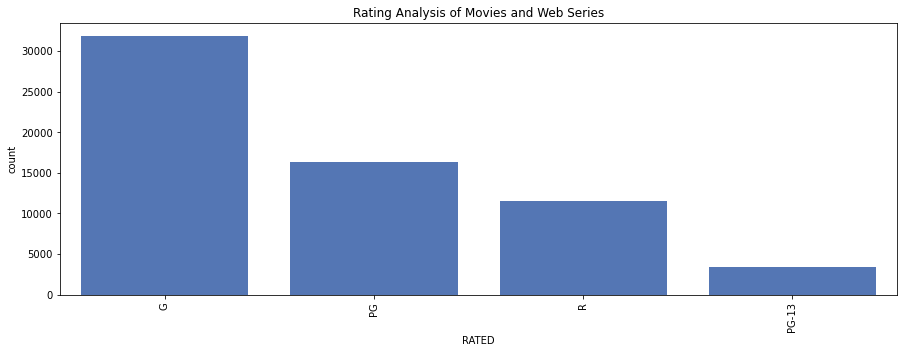

In [25]:
# Analysis of Rated Movies and Web Series
plt.figure(figsize=(15,5))
sns.countplot(x="RATED", data = movie_series_df, color ="#4472C4", order = movie_series_df['RATED'].value_counts().index[0:19])
plt.title('Rating Analysis of Movies and Web Series')
plt.xticks(rotation=90)
plt.show()

<AxesSubplot:title={'center':'Year Wise Analysis'}, xlabel='count', ylabel='YEAR'>

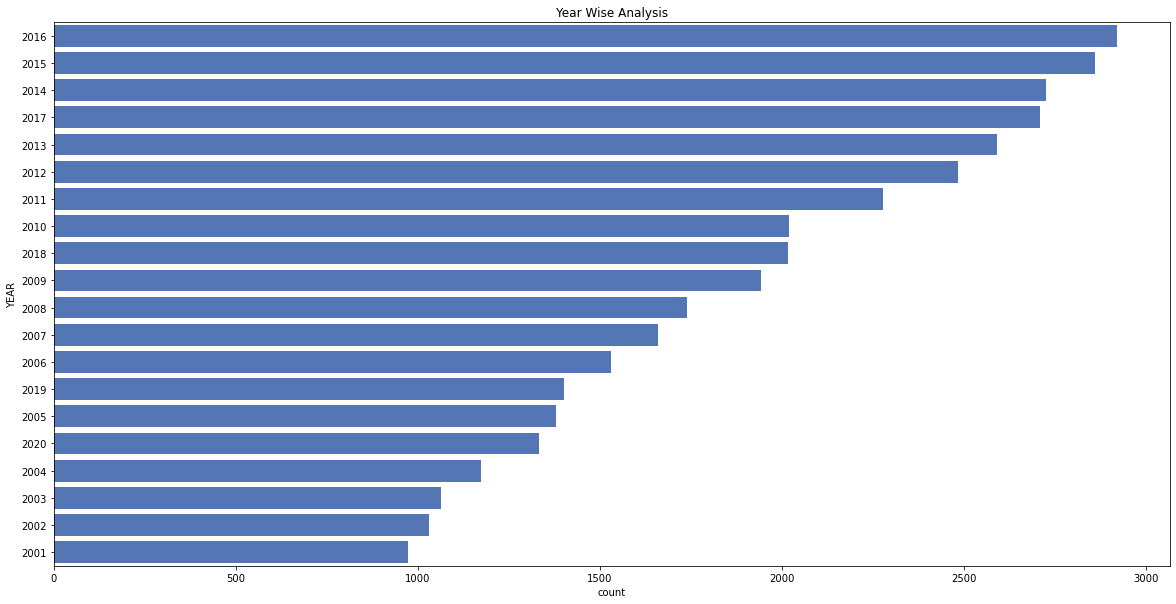

In [26]:
# Year Wise Analysis
plt.figure(figsize=(20,10))
plt.title('Year Wise Analysis')
sns.countplot(y ="YEAR", data = movie_series_df, color ="#4472C4", order = movie_series_df['YEAR'].value_counts().index[0:20])

<AxesSubplot:title={'center':'Genre Wise Analysis'}, xlabel='count', ylabel='GENRE'>

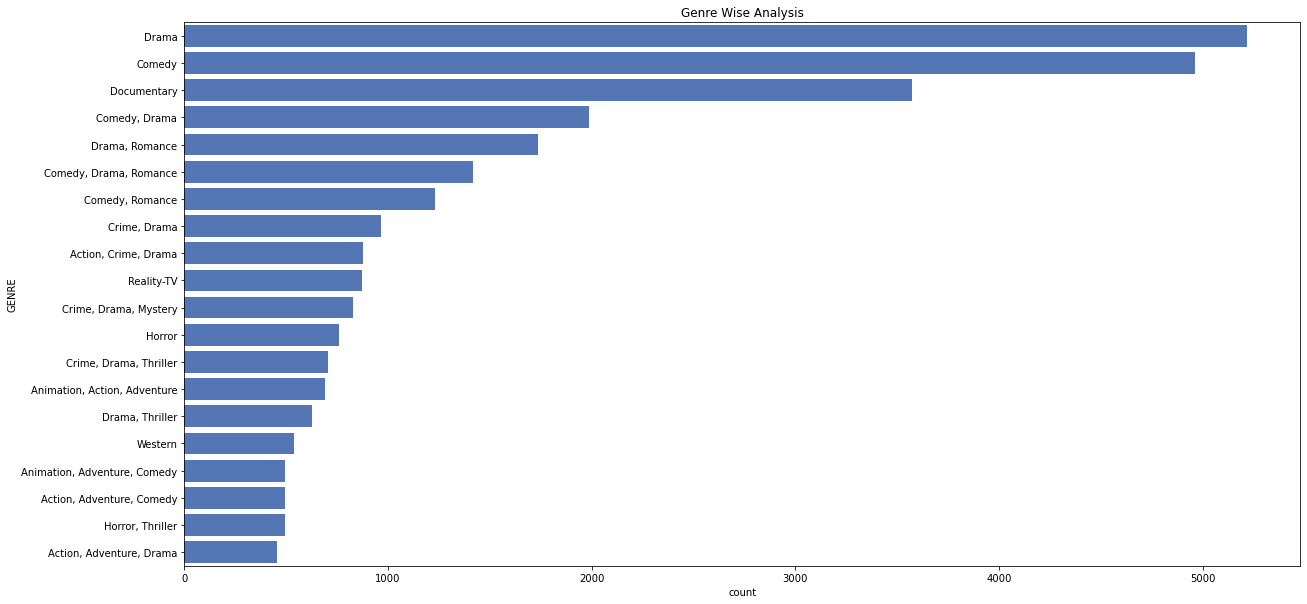

In [27]:
# Genre Wise Analysis
plt.figure(figsize=(20,10))
plt.title('Genre Wise Analysis')
sns.countplot(y ="GENRE", data = movie_series_df, color ="#4472C4", order = movie_series_df['GENRE'].value_counts().index[0:20])

<AxesSubplot:title={'center':'Language Wise Analysis'}, xlabel='count', ylabel='LANGUAGES'>

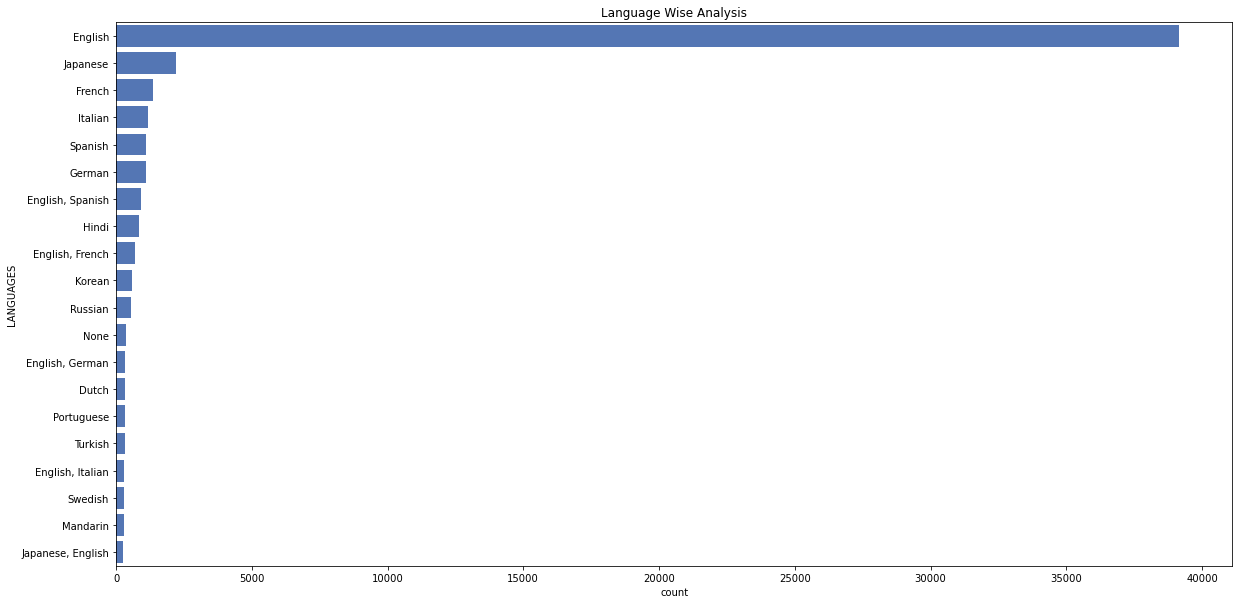

In [28]:
# Language Wise Analysis
plt.figure(figsize=(20,10))
plt.title('Language Wise Analysis')
sns.countplot(y ="LANGUAGES", data = movie_series_df, color ="#4472C4", order = movie_series_df['LANGUAGES'].value_counts().index[0:20])

In [29]:
mv_srs_user_df

,USER_ID,TITLE_ID
0,1,307
1,1,481
2,1,1091
3,1,1257
4,1,1449
...,...,...
1669779,3627,199056
1669780,3627,199210
1669781,3627,194882
1669782,3627,217207


In [30]:
%%time
# Merge movie and movie_uid to get User ID for the movie dataset
mv_srs_user_df = pd.merge(mv_srs_user_df, movie_series_df)
mv_srs_user_df.shape

CPU times: user 287 ms, sys: 71.7 ms, total: 359 ms
Wall time: 372 ms


(1350397, 11)

# Dataset Sampling 

In [31]:
mv_srs_user_sample_df_1 = mv_srs_user_df.query('1 <= USER_ID <= 100')
mv_srs_user_sample_df_2 = mv_srs_user_df.query('1000 <= USER_ID <= 1100')
mv_srs_user_sample_df_3 = mv_srs_user_df.query('2000 <= USER_ID <= 2100')
mv_srs_user_sample_df_4 = mv_srs_user_df.query('3000 <= USER_ID <= 3100')
mv_srs_user_sample_df_5 = mv_srs_user_df.query('4000 <= USER_ID <= 4100')
mv_srs_user_sample_df_6 = mv_srs_user_df.query('5000 <= USER_ID <= 5100')
mv_srs_user_sample_df_7 = mv_srs_user_df.query('6000 <= USER_ID <= 6100')
mv_srs_user_sample_df_8 = mv_srs_user_df.query('7000 <= USER_ID <= 7100')
mv_srs_user_sample_df_9 = mv_srs_user_df.query('8000 <= USER_ID <= 8100')
mv_srs_user_sample_df_10 = mv_srs_user_df.query('9000 <= USER_ID <= 9100')
mv_srs_user_sample_df_11 = mv_srs_user_df.query('9900 <= USER_ID <= 10000')

# List of your dataframes
pdList = [mv_srs_user_sample_df_1, mv_srs_user_sample_df_2, mv_srs_user_sample_df_3, mv_srs_user_sample_df_4, mv_srs_user_sample_df_5,
          mv_srs_user_sample_df_6, mv_srs_user_sample_df_7, mv_srs_user_sample_df_8, mv_srs_user_sample_df_9, mv_srs_user_sample_df_10,
          mv_srs_user_sample_df_11] 
mv_srs_user_sample_df = pd.concat(pdList)
print(mv_srs_user_sample_df.shape)
mv_srs_user_sample_df.head()

(146631, 11)


,USER_ID,TITLE_ID,TITLE,IMDB_SCORE,TYPE,GENRE,POSTER,ACTORS,RATED,LANGUAGES,YEAR
0,1,307,Three Colors: Blue,7.9,movie,"Drama, Music, Mystery",https://m.media-amazon.com/images/M/MV5BZWU5NW...,"Juliette Binoche, Zbigniew Zamachowski, Julie ...",R,French,1993
1,6,307,Three Colors: Blue,7.9,movie,"Drama, Music, Mystery",https://m.media-amazon.com/images/M/MV5BZWU5NW...,"Juliette Binoche, Zbigniew Zamachowski, Julie ...",R,French,1993
2,56,307,Three Colors: Blue,7.9,movie,"Drama, Music, Mystery",https://m.media-amazon.com/images/M/MV5BZWU5NW...,"Juliette Binoche, Zbigniew Zamachowski, Julie ...",R,French,1993
3,71,307,Three Colors: Blue,7.9,movie,"Drama, Music, Mystery",https://m.media-amazon.com/images/M/MV5BZWU5NW...,"Juliette Binoche, Zbigniew Zamachowski, Julie ...",R,French,1993
4,84,307,Three Colors: Blue,7.9,movie,"Drama, Music, Mystery",https://m.media-amazon.com/images/M/MV5BZWU5NW...,"Juliette Binoche, Zbigniew Zamachowski, Julie ...",R,French,1993


In [32]:
mv_srs_user_sample_df

,USER_ID,TITLE_ID,TITLE,IMDB_SCORE,TYPE,GENRE,POSTER,ACTORS,RATED,LANGUAGES,YEAR
0,1,307,Three Colors: Blue,7.9,movie,"Drama, Music, Mystery",https://m.media-amazon.com/images/M/MV5BZWU5NW...,"Juliette Binoche, Zbigniew Zamachowski, Julie ...",R,French,1993
1,6,307,Three Colors: Blue,7.9,movie,"Drama, Music, Mystery",https://m.media-amazon.com/images/M/MV5BZWU5NW...,"Juliette Binoche, Zbigniew Zamachowski, Julie ...",R,French,1993
2,56,307,Three Colors: Blue,7.9,movie,"Drama, Music, Mystery",https://m.media-amazon.com/images/M/MV5BZWU5NW...,"Juliette Binoche, Zbigniew Zamachowski, Julie ...",R,French,1993
3,71,307,Three Colors: Blue,7.9,movie,"Drama, Music, Mystery",https://m.media-amazon.com/images/M/MV5BZWU5NW...,"Juliette Binoche, Zbigniew Zamachowski, Julie ...",R,French,1993
4,84,307,Three Colors: Blue,7.9,movie,"Drama, Music, Mystery",https://m.media-amazon.com/images/M/MV5BZWU5NW...,"Juliette Binoche, Zbigniew Zamachowski, Julie ...",R,French,1993
...,...,...,...,...,...,...,...,...,...,...,...
1333355,10000,197912,Capitol Critters,7.0,series,"Animation, Comedy, Drama",https://m.media-amazon.com/images/M/MV5BNzNjYT...,"Neil Patrick Harris, Charlie Adler, Patti Deutsch",PG,English,1992
1334051,10000,210380,Sword of the Atom,7.2,series,"Animation, Sci-Fi",https://m.media-amazon.com/images/M/MV5BYjQ2ZD...,"Jason Marsden, David Kaye, Armin Shimerman",G,English,2012
1338040,10000,216842,H3 Podcast,6.9,series,"Comedy, Talk-Show",https://m.media-amazon.com/images/M/MV5BODZhYm...,"Ethan Klein, Hila Klein",PG,English,2016
1338167,10000,195248,Doctor's Orders,6.5,series,"Documentary, Crime",https://m.media-amazon.com/images/M/MV5BOGUzNT...,"Kim Pack, Adal Ray, Damon Tyner",G,English,2021


In [33]:
#Creating EDA Data again for visualizing RATED, YEAR, GENRE, LANGUAGE
mv_srs_user_sample_df_eda = mv_srs_user_sample_df.drop_duplicates(subset=['TITLE_ID', 'TYPE', 'IMDB_SCORE'])
mv_srs_user_sample_df_eda

,USER_ID,TITLE_ID,TITLE,IMDB_SCORE,TYPE,GENRE,POSTER,ACTORS,RATED,LANGUAGES,YEAR
0,1,307,Three Colors: Blue,7.9,movie,"Drama, Music, Mystery",https://m.media-amazon.com/images/M/MV5BZWU5NW...,"Juliette Binoche, Zbigniew Zamachowski, Julie ...",R,French,1993
332,1,481,Kalifornia,6.7,movie,"Crime, Drama, Thriller",https://m.media-amazon.com/images/M/MV5BNDE2OD...,"Brad Pitt, Juliette Lewis, Kathy Larson",R,English,1993
598,1,1091,Curtis's Charm,6.7,movie,"Comedy, Drama",https://m.media-amazon.com/images/M/MV5BY2MxOD...,"Maurice Dean Wint, Callum Keith Rennie, Rachae...",G,English,1995
825,1,1257,Better Off Dead...,7.1,movie,"Comedy, Romance",https://m.media-amazon.com/images/M/MV5BMzRmMj...,"John Cusack, David Ogden Stiers, Kim Darby",PG,English,1985
1066,1,1449,Waiting for Guffman,7.4,movie,Comedy,https://m.media-amazon.com/images/M/MV5BYWY4OG...,"Christopher Guest, Fred Willard, Catherine O'Hara",R,English,1996
...,...,...,...,...,...,...,...,...,...,...,...
1326548,9988,195661,Life with Elizabeth,7.3,series,Comedy,https://m.media-amazon.com/images/M/MV5BMWUwYz...,"Betty White, Del Moore, Jack Narz",G,English,1952
1326596,9989,206848,Livet i Fagervik,7.0,series,Drama,https://m.media-amazon.com/images/M/MV5BOTk5ZT...,"Henrik Johansson, Maria Sid, Lars Lind",G,Swedish,2008
1327843,9999,207549,Atashinchi no danshi,7.1,series,Comedy,https://m.media-amazon.com/images/M/MV5BZjUwMz...,"Maki Horikita, Jun Kaname, Yoshinori Okada",G,Japanese,2009
1328997,10000,202851,Waltz,7.9,series,Drama,https://m.media-amazon.com/images/M/MV5BMTQwMD...,"Aart Staartjes, Olga Louzgina, Theo Maassen",G,Dutch,2006


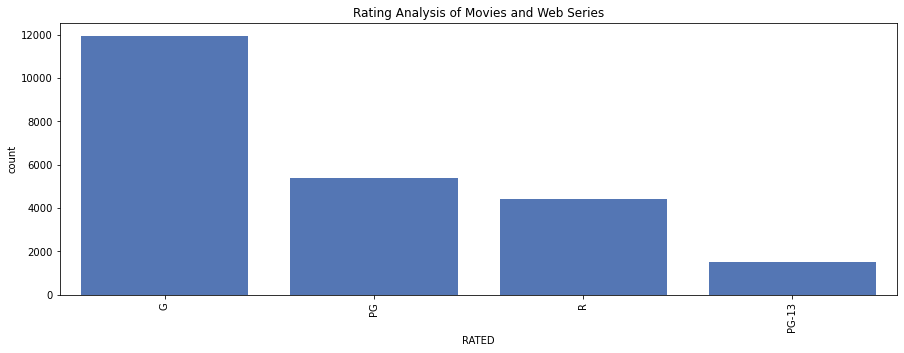

In [34]:
# Analysis of Rated Movies and Web Series after sampling
plt.figure(figsize=(15,5))
sns.countplot(x="RATED", data = mv_srs_user_sample_df_eda, color ="#4472C4", order = mv_srs_user_sample_df_eda['RATED'].value_counts().index[0:19])
plt.title('Rating Analysis of Movies and Web Series')
plt.xticks(rotation=90)
plt.show()

<AxesSubplot:title={'center':'Year Wise Analysis'}, xlabel='count', ylabel='YEAR'>

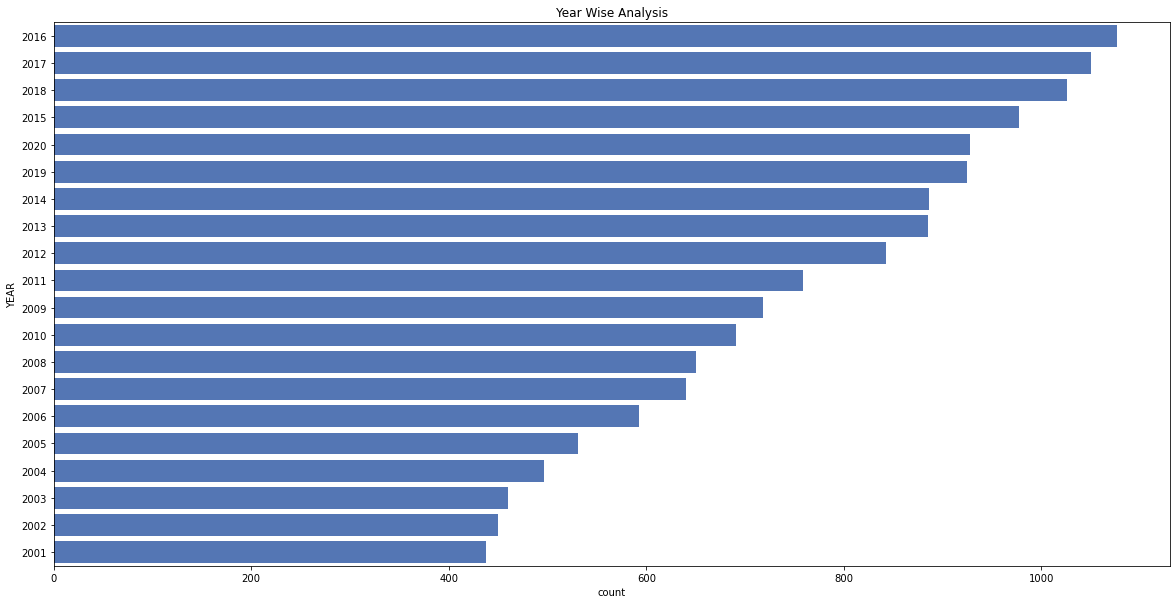

In [35]:
# Year Wise Analysis after sampling
plt.figure(figsize=(20,10))
plt.title('Year Wise Analysis')
sns.countplot(y ="YEAR", data = mv_srs_user_sample_df_eda, color ="#4472C4", order = mv_srs_user_sample_df_eda['YEAR'].value_counts().index[0:20])

<AxesSubplot:title={'center':'Genre Wise Analysis'}, xlabel='count', ylabel='GENRE'>

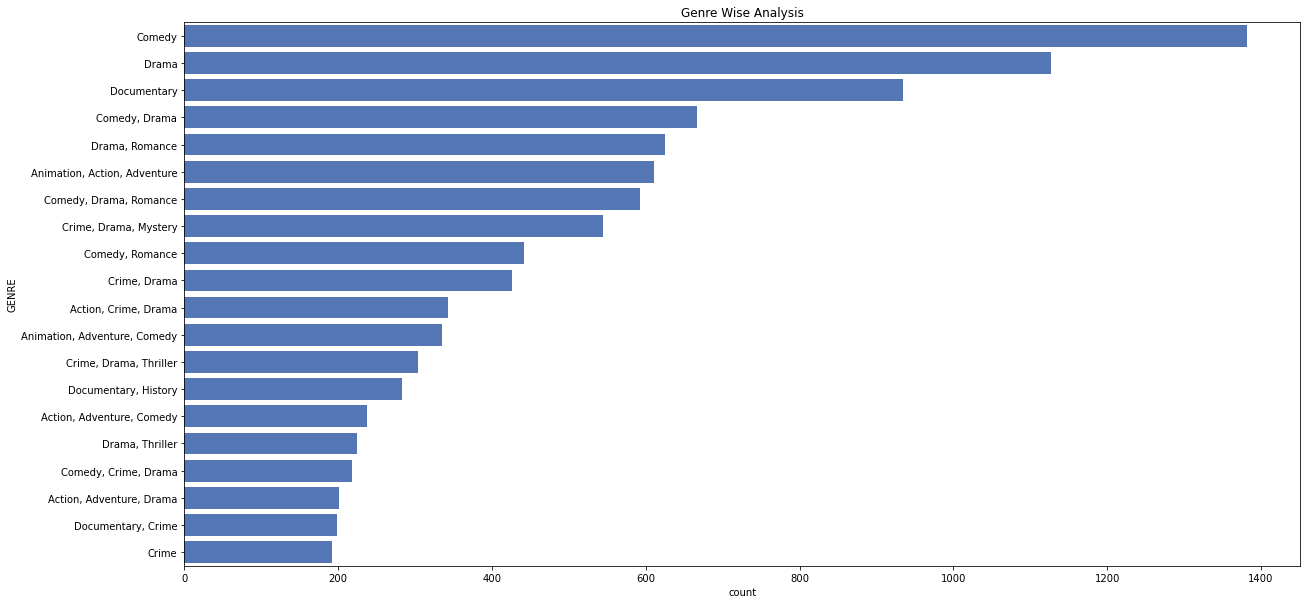

In [36]:
# Genre Wise Analysis after sampling
plt.figure(figsize=(20,10))
plt.title('Genre Wise Analysis')
sns.countplot(y ="GENRE", data = mv_srs_user_sample_df_eda, color ="#4472C4", order = mv_srs_user_sample_df_eda['GENRE'].value_counts().index[0:20])

<AxesSubplot:title={'center':'Language Wise Analysis'}, xlabel='count', ylabel='LANGUAGES'>

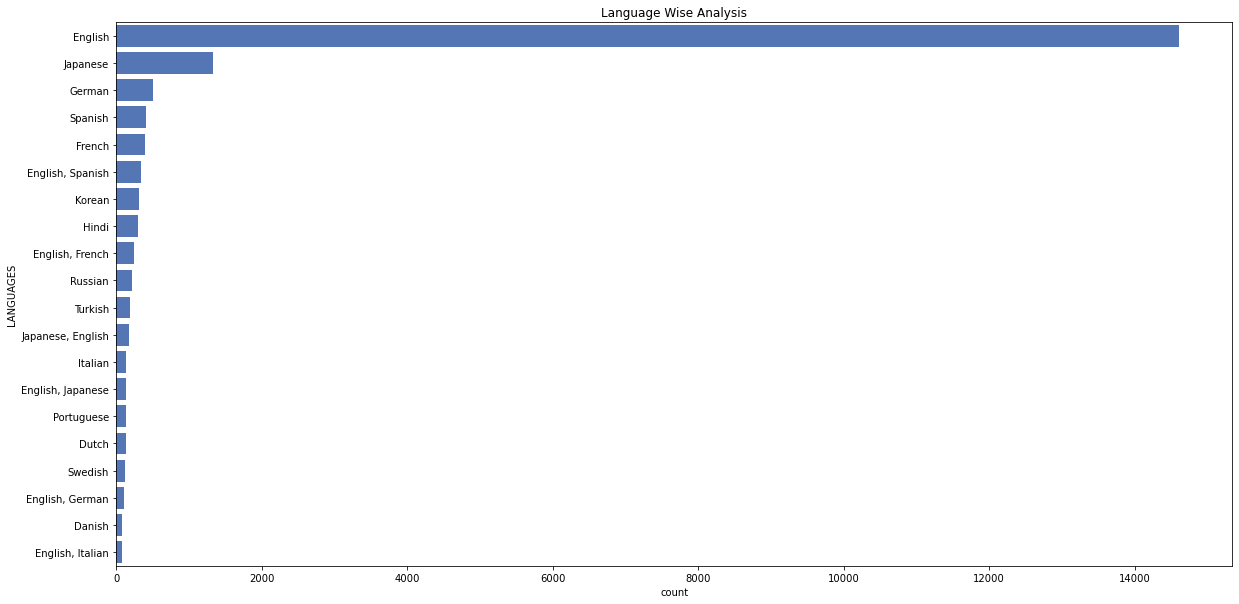

In [37]:
# Language Wise Analysis after sampling
plt.figure(figsize=(20,10))
plt.title('Language Wise Analysis')
sns.countplot(y ="LANGUAGES", data = mv_srs_user_sample_df_eda, color ="#4472C4", order = mv_srs_user_sample_df_eda['LANGUAGES'].value_counts().index[0:20])

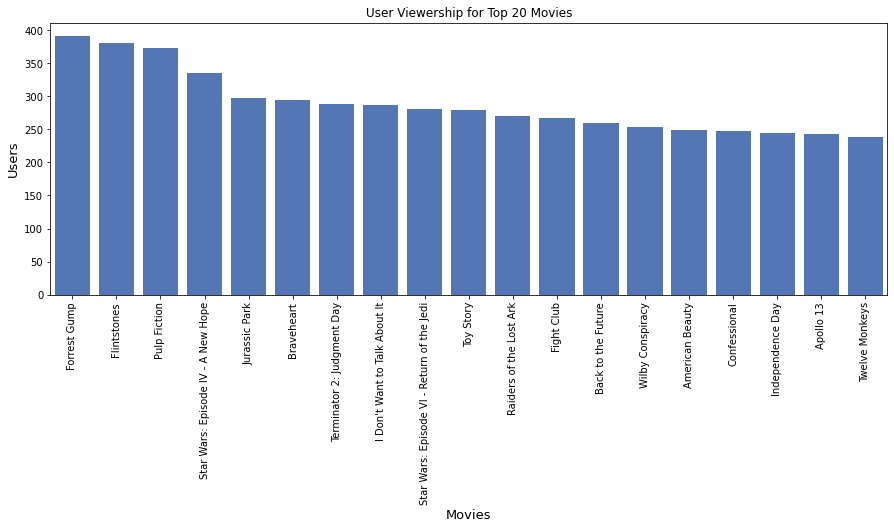

In [38]:
# Analysis of User Viewership for Top 20 Movies after sampling
plt.figure(figsize=(15,5))
sns.countplot(x="TITLE", data = mv_srs_user_sample_df, color ="#4472C4", order = mv_srs_user_sample_df.loc[mv_srs_user_sample_df['TYPE'] == 'movie']['TITLE'].value_counts().index[0:19])
plt.title('User Viewership for Top 20 Movies')
plt.xticks(rotation=90)
plt.ylabel('Users', fontsize=13)
plt.xlabel('Movies', fontsize=13)
plt.show()

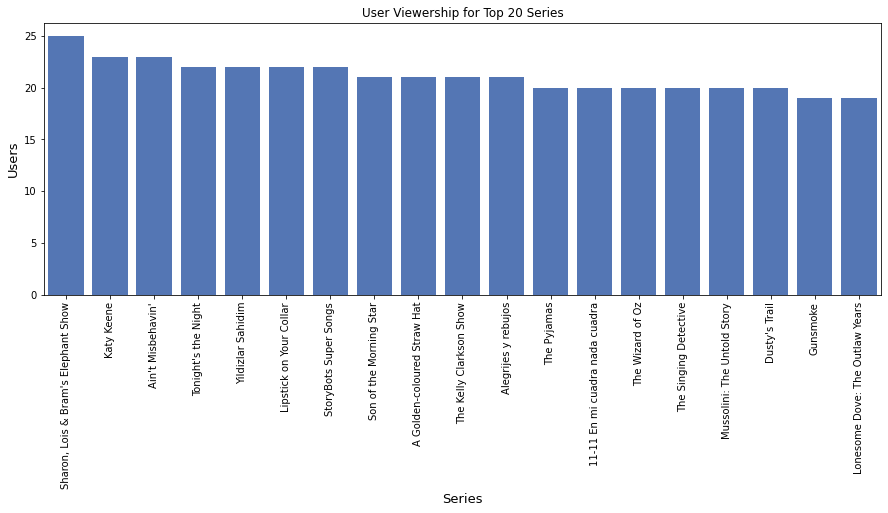

In [39]:
# Analysis of User Viewership for Top 20 Web Series after sampling
plt.figure(figsize=(15,5))
sns.countplot(x="TITLE", data = mv_srs_user_sample_df, color ="#4472C4", order = mv_srs_user_sample_df.loc[mv_srs_user_sample_df['TYPE'] == 'series']['TITLE'].value_counts().index[0:19])
plt.title('User Viewership for Top 20 Series')
plt.xticks(rotation=90)
plt.ylabel('Users', fontsize=13)
plt.xlabel('Series', fontsize=13)
plt.show()

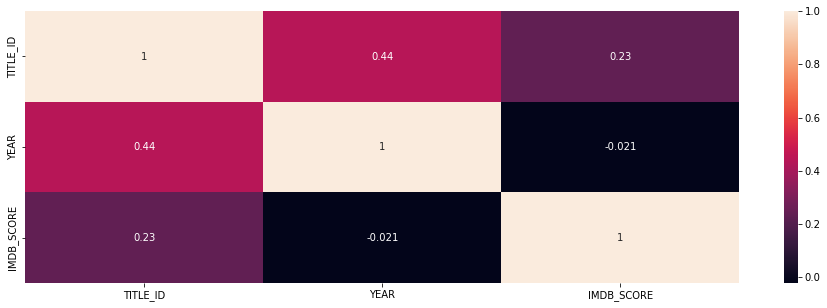

CPU times: user 204 ms, sys: 12.9 ms, total: 217 ms
Wall time: 219 ms


,USER_ID,TITLE_ID,TITLE,IMDB_SCORE,TYPE,GENRE,POSTER,ACTORS,RATED,LANGUAGES,YEAR
0,1,307,Three Colors: Blue,7.9,movie,"Drama, Music, Mystery",https://m.media-amazon.com/images/M/MV5BZWU5NW...,"Juliette Binoche, Zbigniew Zamachowski, Julie ...",R,French,1993
1,6,307,Three Colors: Blue,7.9,movie,"Drama, Music, Mystery",https://m.media-amazon.com/images/M/MV5BZWU5NW...,"Juliette Binoche, Zbigniew Zamachowski, Julie ...",R,French,1993
2,56,307,Three Colors: Blue,7.9,movie,"Drama, Music, Mystery",https://m.media-amazon.com/images/M/MV5BZWU5NW...,"Juliette Binoche, Zbigniew Zamachowski, Julie ...",R,French,1993
3,71,307,Three Colors: Blue,7.9,movie,"Drama, Music, Mystery",https://m.media-amazon.com/images/M/MV5BZWU5NW...,"Juliette Binoche, Zbigniew Zamachowski, Julie ...",R,French,1993
4,84,307,Three Colors: Blue,7.9,movie,"Drama, Music, Mystery",https://m.media-amazon.com/images/M/MV5BZWU5NW...,"Juliette Binoche, Zbigniew Zamachowski, Julie ...",R,French,1993
...,...,...,...,...,...,...,...,...,...,...,...
1333355,10000,197912,Capitol Critters,7.0,series,"Animation, Comedy, Drama",https://m.media-amazon.com/images/M/MV5BNzNjYT...,"Neil Patrick Harris, Charlie Adler, Patti Deutsch",PG,English,1992
1334051,10000,210380,Sword of the Atom,7.2,series,"Animation, Sci-Fi",https://m.media-amazon.com/images/M/MV5BYjQ2ZD...,"Jason Marsden, David Kaye, Armin Shimerman",G,English,2012
1338040,10000,216842,H3 Podcast,6.9,series,"Comedy, Talk-Show",https://m.media-amazon.com/images/M/MV5BODZhYm...,"Ethan Klein, Hila Klein",PG,English,2016
1338167,10000,195248,Doctor's Orders,6.5,series,"Documentary, Crime",https://m.media-amazon.com/images/M/MV5BOGUzNT...,"Kim Pack, Adal Ray, Damon Tyner",G,English,2021


In [40]:
%%time
mv_srs_user_corr_df = mv_srs_user_sample_df.drop(['TITLE', 'USER_ID'], axis = 1)
mv_srs_user_corr_df = mv_srs_user_corr_df.drop_duplicates(subset=['TITLE_ID'], keep=False)
plt.figure(figsize = (16,5))
ax = sns.heatmap(mv_srs_user_corr_df[['TITLE_ID', 'YEAR', 'IMDB_SCORE']].corr(), annot=True)
plt.show()
mv_srs_user_sample_df

In [41]:
# Get the basic info about the data (range, datatypes of each attribute)
mv_srs_user_sample_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 146631 entries, 0 to 1338178
Data columns (total 11 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   USER_ID     146631 non-null  int64  
 1   TITLE_ID    146631 non-null  int64  
 2   TITLE       146631 non-null  object 
 3   IMDB_SCORE  146631 non-null  float64
 4   TYPE        146631 non-null  object 
 5   GENRE       146631 non-null  object 
 6   POSTER      146631 non-null  object 
 7   ACTORS      146631 non-null  object 
 8   RATED       146631 non-null  object 
 9   LANGUAGES   146631 non-null  object 
 10  YEAR        146631 non-null  int64  
dtypes: float64(1), int64(3), object(7)
memory usage: 13.4+ MB


In [42]:
# Statistical summary for the numerical attributes
mv_srs_user_sample_df.describe().round(1)

,USER_ID,TITLE_ID,IMDB_SCORE,YEAR
count,146631.0,146631.0,146631.0,146631.0
mean,4938.1,98536.2,7.1,1998.5
std,3233.8,95433.2,1.1,17.0
min,1.0,1.0,1.0,1894.0
25%,2039.0,2359.0,6.5,1992.0
50%,5027.0,67734.0,7.2,2000.0
75%,8035.0,203121.5,7.8,2011.0
max,10000.0,219605.0,10.0,2022.0


In [43]:
# Statistical summary for the categorical attributes
mv_srs_user_sample_df[['TITLE','TYPE','GENRE', 'RATED','LANGUAGES']].describe(include='object').T

,count,unique,top,freq
TITLE,146631,22987,Forrest Gump,392
TYPE,146631,2,movie,86052
GENRE,146631,1175,Drama,4633
RATED,146631,4,G,50976
LANGUAGES,146631,1374,English,97329


OBSERVATION:
Total number of movies and series present in the dataset is 40,721.
Comedy Genre is the most frequently occuring genre in the dataset.
Most popular movie/series is forrest gump.
Series is popular among users.
Most of the movies and series are in English Language.

In [44]:
movies_df.columns

Index(['TITLE_ID', 'TITLE', 'IMDB_SCORE', 'TYPE', 'GENRE', 'POSTER', 'ACTORS',
       'RATED', 'LANGUAGES', 'YEAR'],
      dtype='object')

In [45]:
mv_srs_user_sample_df.columns

Index(['USER_ID', 'TITLE_ID', 'TITLE', 'IMDB_SCORE', 'TYPE', 'GENRE', 'POSTER',
       'ACTORS', 'RATED', 'LANGUAGES', 'YEAR'],
      dtype='object')

In [46]:
mv_srs_user_sample_df = mv_srs_user_sample_df.drop(['POSTER', 'ACTORS'], axis = 1)

In [47]:
mv_srs_user_sample_df.describe(include = 'object').T

,count,unique,top,freq
TITLE,146631,22987,Forrest Gump,392
TYPE,146631,2,movie,86052
GENRE,146631,1175,Drama,4633
RATED,146631,4,G,50976
LANGUAGES,146631,1374,English,97329


In [48]:
mv_srs_user_sample_df.shape

(146631, 9)

# Genre Splitting & Encoding

In [49]:
# Splitting Genres into different columns. Here we just create columns and put there initial value as 0
genres = mv_srs_user_sample_df.GENRE
a = list()
for i in genres:
    genre = i
    a.append(genre.split(','))
a = pd.DataFrame(a)   
b = a[0].unique()
for i in b:
    mv_srs_user_sample_df[i] = 0
mv_srs_user_sample_df.head(2)

,USER_ID,TITLE_ID,TITLE,IMDB_SCORE,TYPE,GENRE,RATED,LANGUAGES,YEAR,Drama,...,Film-Noir,Music,Musical,Game-Show,Sport,War,History,News,Reality-TV,Talk-Show
0,1,307,Three Colors: Blue,7.9,movie,"Drama, Music, Mystery",R,French,1993,0,...,0,0,0,0,0,0,0,0,0,0
1,6,307,Three Colors: Blue,7.9,movie,"Drama, Music, Mystery",R,French,1993,0,...,0,0,0,0,0,0,0,0,0,0


In [50]:
mv_srs_user_sample_df.shape

(146631, 37)

In [51]:
# Assign 1 to all the columns which are present in the Genres
for i in b:
    mv_srs_user_sample_df.loc[mv_srs_user_sample_df['GENRE'].str.contains(i), i] = 1

mv_srs_user_sample_df.sample(10)

,USER_ID,TITLE_ID,TITLE,IMDB_SCORE,TYPE,GENRE,RATED,LANGUAGES,YEAR,Drama,...,Film-Noir,Music,Musical,Game-Show,Sport,War,History,News,Reality-TV,Talk-Show
670911,1073,2188,54,5.8,movie,"Drama, Music",R,English,1998,1,...,0,1,0,0,0,0,0,0,0,0
1148070,1052,204805,The Movies That Made Us,7.6,series,"Documentary, Family, History",PG,English,2019,0,...,0,0,0,0,0,0,1,0,0,0
609608,1055,34334,Stealth,5.0,movie,"Action, Adventure, Sci-Fi",PG-13,"English, Korean, Russian, Spanish",2005,0,...,0,0,0,0,0,0,0,0,0,0
170457,1040,1779,Sphere,6.1,movie,"Action, Mystery, Sci-Fi",PG-13,English,1998,0,...,0,0,0,0,0,0,0,0,0,0
1126924,1042,212531,Gap Dong,7.4,series,"Crime, Drama, Mystery",G,Korean,2014,1,...,0,0,0,0,0,0,0,0,0,0
844011,5055,203968,Ijon Tichy: Raumpilot,7.6,series,"Comedy, Sci-Fi",G,German,2007,0,...,0,0,0,0,0,0,0,0,0,0
710545,9010,5957,Two Weeks Notice,6.1,movie,"Comedy, Romance",PG-13,English,2002,0,...,0,0,0,0,0,0,0,0,0,0
164810,1094,1682,Great Mouse Detective,7.2,movie,"Animation, Adventure, Family",G,English,1986,0,...,0,0,0,0,0,0,0,0,0,0
149651,4048,1270,Back to the Future,8.5,movie,"Adventure, Comedy, Sci-Fi",PG,English,1985,0,...,0,0,0,0,0,0,0,0,0,0
1323047,9051,207491,The League of Super Evil,6.4,series,"Animation, Action, Comedy",G,English,2009,0,...,0,0,0,0,0,0,0,0,0,0


In [52]:
# Capitalize the column names
mv_srs_user_sample_df.columns = map(lambda x: str(x).upper(), mv_srs_user_sample_df.columns)

mv_srs_user_sample_df.head(2)

,USER_ID,TITLE_ID,TITLE,IMDB_SCORE,TYPE,GENRE,RATED,LANGUAGES,YEAR,DRAMA,...,FILM-NOIR,MUSIC,MUSICAL,GAME-SHOW,SPORT,WAR,HISTORY,NEWS,REALITY-TV,TALK-SHOW
0,1,307,Three Colors: Blue,7.9,movie,"Drama, Music, Mystery",R,French,1993,1,...,0,1,0,0,0,0,0,0,0,0
1,6,307,Three Colors: Blue,7.9,movie,"Drama, Music, Mystery",R,French,1993,1,...,0,1,0,0,0,0,0,0,0,0


In [53]:
#Feature Selection for Clustering
columns_to_cluster = ['USER_ID', 'TITLE_ID', 'DRAMA', 'CRIME', 'COMEDY', 'HORROR', 'ACTION', 'SHORT', 'ADVENTURE', 'FANTASY', 'ANIMATION', 'BIOGRAPHY', 'DOCUMENTARY', 'MYSTERY', 'THRILLER', 'WESTERN', 'ADULT', 'SCI-FI', 'FAMILY', 'ROMANCE',
 'FILM-NOIR', 'MUSIC', 'MUSICAL', 'GAME-SHOW', 'SPORT', 'WAR', 'HISTORY', 'NEWS', 'REALITY-TV', 'TALK-SHOW']


# Scaling the sample dataset

In [54]:
from sklearn.preprocessing import RobustScaler
ss = RobustScaler()
mv_srs_user_sample_df_scaled = ss.fit_transform(mv_srs_user_sample_df[columns_to_cluster])

In [55]:
columns_to_cluster_scaled = ['USER_ID_SCALED', 'TITLE_ID_SCALED', 'DRAMA_SCALED', 'CRIME_SCALED', 'COMEDY_SCALED', 'HORROR_SCALED', 'ACTION_SCALED', 'SHORT_SCALED',
                             'ADVENTURE_SCALED', 'FANTASY_SCALED', 'ANIMATION_SCALED', 'BIOGRAPHY_SCALED', 'DOCUMENTARY_SCALED', 'MYSTERY_SCALED', 'THRILLER_SCALED', 
                             'WESTERN_SCALED', 'ADULT_SCALED', 'SCI-FI_SCALED', 'FAMILY_SCALED', 'ROMANCE_SCALED', 'FILM-NOIR_SCALED', 'MUSIC_SCALED', 'MUSICAL_SCALED', 
                             'GAME-SHOW_SCALED', 'SPORT_SCALED', 'WAR_SCALED', 'HISTORY_SCALED', 'NEWS_SCALED', 'REALITY-TV_SCALED', 'TALK-SHOW_SCALED']

mv_srs_user_sample_df_scaled_2 = pd.DataFrame(mv_srs_user_sample_df_scaled, columns=columns_to_cluster_scaled)
list(mv_srs_user_sample_df_scaled_2.columns)
mv_srs_user_sample_df_scaled_2.head()

,USER_ID_SCALED,TITLE_ID_SCALED,DRAMA_SCALED,CRIME_SCALED,COMEDY_SCALED,HORROR_SCALED,ACTION_SCALED,SHORT_SCALED,ADVENTURE_SCALED,FANTASY_SCALED,...,FILM-NOIR_SCALED,MUSIC_SCALED,MUSICAL_SCALED,GAME-SHOW_SCALED,SPORT_SCALED,WAR_SCALED,HISTORY_SCALED,NEWS_SCALED,REALITY-TV_SCALED,TALK-SHOW_SCALED
0,-0.838225,-0.335855,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,-0.837392,-0.335855,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,-0.829053,-0.335855,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,-0.826551,-0.335855,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,-0.824383,-0.335855,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


# Model Building

**Silhouette Visualizer**

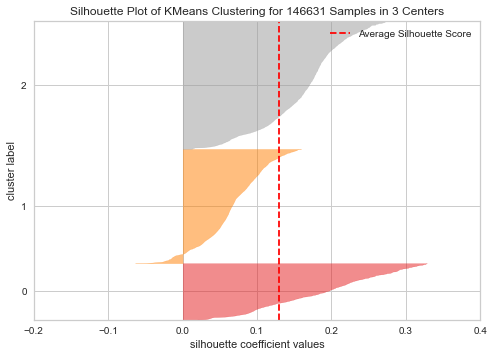

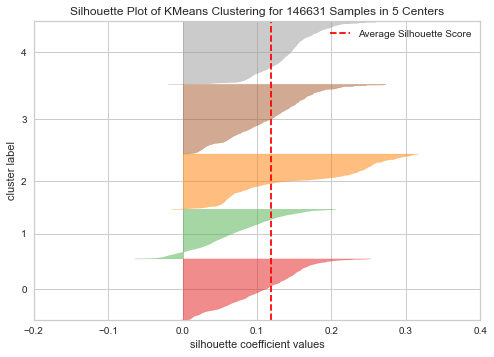

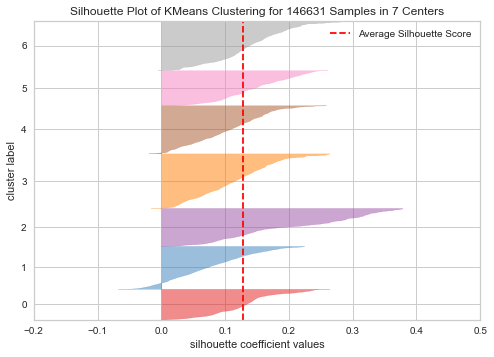

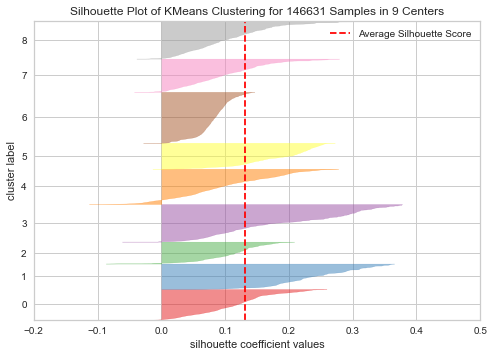

CPU times: user 42min 18s, sys: 11min 20s, total: 53min 39s
Wall time: 39min 56s


In [56]:
%%time
from yellowbrick.cluster import SilhouetteVisualizer

for i in [3, 5, 7, 9]:
    '''
    Create KMeans instance for different number of clusters
    '''
    km = KMeans(n_clusters = i, random_state = 10)
    '''
    Create SilhouetteVisualizer instance with KMeans instance
    Fit the visualizer
    '''

    visualizer = SilhouetteVisualizer(km)

    visualizer.fit(mv_srs_user_sample_df_scaled_2)
    visualizer.show()    

**Davies Bouldin Index and** **Calinski Harabasz**

In [57]:
%%time
# Find Optimal number of k Using Silhouette score and metric Euclidean distance
n_clusters = [3, 5, 7, 9]

for k in n_clusters:
    cluster = KMeans(n_clusters = k, random_state = 10)
    predict = cluster.fit_predict(mv_srs_user_sample_df_scaled_2)
    
    # Check the accuracy of the model Using Davies Bouldin Score
    db_index = davies_bouldin_score(mv_srs_user_sample_df_scaled_2, predict)
    print("For n_clusters = {}, davies_bouldin_score is {}".format(k, db_index))
    
    # Check the accuracy of the model Using Calinski Harabasz Score
    ch_index = calinski_harabasz_score(mv_srs_user_sample_df_scaled_2, predict)
    print("For n_clusters = {}, calinski_harabasz_score is {}".format(k, ch_index))

For n_clusters = 3, davies_bouldin_score is 2.5160296297991622
For n_clusters = 3, calinski_harabasz_score is 16777.819805361098
For n_clusters = 5, davies_bouldin_score is 2.4673429001366314
For n_clusters = 5, calinski_harabasz_score is 13827.871392490375
For n_clusters = 7, davies_bouldin_score is 2.2270803219466386
For n_clusters = 7, calinski_harabasz_score is 12022.338393613976
For n_clusters = 9, davies_bouldin_score is 2.1637192340509053
For n_clusters = 9, calinski_harabasz_score is 10605.658441379235
CPU times: user 35 s, sys: 1.42 s, total: 36.4 s
Wall time: 10.2 s


**Silhouette score using metrics as euclidean and** **manhattan**

In [58]:
%%time
# Find Optimal number of k Using Silhouette score and metric Euclidean distance
n_clusters = [3, 5, 7, 9]

for k in n_clusters:
    cluster = KMeans(n_clusters = k, random_state = 10)
    predict = cluster.fit_predict(mv_srs_user_sample_df_scaled_2)  
    score = silhouette_score(mv_srs_user_sample_df_scaled_2, predict, metric = 'euclidean')
    print("For n_clusters = {}, silhouette score is {}".format(k, score))

For n_clusters = 3, silhouette score is 0.1292843275006286
For n_clusters = 5, silhouette score is 0.11865622135159065
For n_clusters = 7, silhouette score is 0.12807667986503957
For n_clusters = 9, silhouette score is 0.13110928680886863
CPU times: user 22min 6s, sys: 6min 5s, total: 28min 11s
Wall time: 22min 24s


In [59]:
mv_srs_user_sample_df_scaled_2

,USER_ID_SCALED,TITLE_ID_SCALED,DRAMA_SCALED,CRIME_SCALED,COMEDY_SCALED,HORROR_SCALED,ACTION_SCALED,SHORT_SCALED,ADVENTURE_SCALED,FANTASY_SCALED,...,FILM-NOIR_SCALED,MUSIC_SCALED,MUSICAL_SCALED,GAME-SHOW_SCALED,SPORT_SCALED,WAR_SCALED,HISTORY_SCALED,NEWS_SCALED,REALITY-TV_SCALED,TALK-SHOW_SCALED
0,-0.838225,-0.335855,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,-0.837392,-0.335855,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,-0.829053,-0.335855,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,-0.826551,-0.335855,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,-0.824383,-0.335855,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
146626,0.829386,0.648418,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
146627,0.829386,0.710521,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
146628,0.829386,0.742708,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
146629,0.829386,0.635148,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


# Model training

In [60]:
%%time
model = KMeans(n_clusters = 9)
model.fit(mv_srs_user_sample_df_scaled_2)

CPU times: user 12.4 s, sys: 356 ms, total: 12.7 s
Wall time: 3.55 s


KMeans(n_clusters=9)

In [61]:
model.labels_

array([1, 1, 1, ..., 4, 6, 6], dtype=int32)

In [62]:
mv_srs_user_sample_df_scaled_2.shape

(146631, 30)

In [63]:
mv_srs_user_sample_df.shape

(146631, 37)

**Merging Sample Dataframe with Cluster**

In [64]:
# Creating an extra column in data for storing the cluster values
mv_srs_user_sample_df['CLUSTER'] = model.labels_
mv_srs_user_sample_df['CLUSTER'].sample(n=10)

816567     0
750961     2
819536     6
556074     4
38395      1
1118277    1
1172249    1
933025     2
23885      2
1062888    1
Name: CLUSTER, dtype: int32

In [65]:
mv_srs_user_sample_df[['CLUSTER','USER_ID', 'TITLE_ID', 'DRAMA','COMEDY','HORROR', 'ACTION', 'SHORT', 'ADVENTURE', 'FANTASY']].sample(15)

,CLUSTER,USER_ID,TITLE_ID,DRAMA,COMEDY,HORROR,ACTION,SHORT,ADVENTURE,FANTASY
500094,7,4016,69481,1,0,0,0,0,0,0
1184364,4,9051,199660,0,1,0,0,0,0,0
306039,8,5061,33794,1,0,0,1,0,0,0
107648,1,2040,590,1,0,0,0,0,1,0
516143,1,4062,2411,1,0,0,0,0,0,0
1031339,1,2063,195102,1,0,1,0,0,0,0
512450,3,43,4855,0,0,0,1,0,0,0
900189,1,3079,196165,1,0,0,0,0,1,0
680055,1,8024,81562,1,0,0,0,0,0,0
785474,8,6078,195844,1,0,0,0,0,0,0


In [66]:
# Check if the cluster has been added to the dataset
mv_srs_user_sample_df.head()

,USER_ID,TITLE_ID,TITLE,IMDB_SCORE,TYPE,GENRE,RATED,LANGUAGES,YEAR,DRAMA,...,MUSIC,MUSICAL,GAME-SHOW,SPORT,WAR,HISTORY,NEWS,REALITY-TV,TALK-SHOW,CLUSTER
0,1,307,Three Colors: Blue,7.9,movie,"Drama, Music, Mystery",R,French,1993,1,...,1,0,0,0,0,0,0,0,0,1
1,6,307,Three Colors: Blue,7.9,movie,"Drama, Music, Mystery",R,French,1993,1,...,1,0,0,0,0,0,0,0,0,1
2,56,307,Three Colors: Blue,7.9,movie,"Drama, Music, Mystery",R,French,1993,1,...,1,0,0,0,0,0,0,0,0,1
3,71,307,Three Colors: Blue,7.9,movie,"Drama, Music, Mystery",R,French,1993,1,...,1,0,0,0,0,0,0,0,0,1
4,84,307,Three Colors: Blue,7.9,movie,"Drama, Music, Mystery",R,French,1993,1,...,1,0,0,0,0,0,0,0,0,1


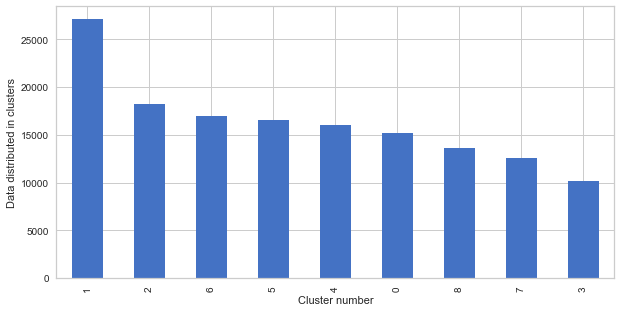

In [67]:
mv_srs_user_sample_df['cluster'] = model.labels_
plt.figure(figsize= (10,5))
mv_srs_user_sample_df['cluster'].value_counts().plot(kind='bar', color ="#4472C4")
plt.xlabel('Cluster number')
plt.ylabel('Data distributed in clusters')
plt.show()

In [68]:
# User and cluster distribution for random users.
user_cluster = mv_srs_user_sample_df[['USER_ID', 'CLUSTER']]
user_cluster.sample(20).T

,1278955,91645,1150973,873371,728206,775910,1293430,1331460,161061,823184,904447,620847,1105767,319894,678222,773494,126811,1122461,104882,508227
USER_ID,7033,1073,7035,5054,3021,9029,9936,7035,6092,5002,38,7001,5047,36,5077,5034,5048,8004,72,5027
CLUSTER,4,5,6,4,2,4,4,6,8,1,7,7,5,1,1,5,1,0,5,7


In [69]:
# TITLE_ID and cluster distribution
id_cluster = mv_srs_user_sample_df[['TITLE_ID', 'CLUSTER']]
id_cluster.head()

,TITLE_ID,CLUSTER
0,307,1
1,307,1
2,307,1
3,307,1
4,307,1


In [70]:
# Create function which will allot cluster to a movie/series 
cluster_titleid_df = []
def allot_cluster(group):
    a = pd.DataFrame(group)
    b = pd.DataFrame(a['CLUSTER'].value_counts())
    c = a.index 
    d = [a['TITLE_ID'][c[0]],int(b.idxmax())]
    cluster_titleid_df.append(d)

In [71]:
# The Cluster which occurs maximum number of times is alloted to the movie  
mv_srs_user_sample_df.groupby("TITLE_ID").apply(lambda x: allot_cluster(x))

""


In [72]:
cluster_titleid_df = pd.DataFrame(cluster_titleid_df)
cluster_titleid_df.head()

,0,1
0,1,0
1,2,2
2,3,2
3,4,7
4,5,2


In [73]:
# Rename the columns
cluster_titleid_df.rename(columns = {0:'TITLE_ID',1:'CLUSTER'},inplace=True)
cluster_titleid_df.head()

,TITLE_ID,CLUSTER
0,1,0
1,2,2
2,3,2
3,4,7
4,5,2


In [74]:
# Merge the merged movie and series dataset and the cluster dataset
movie_series_cluster_df = pd.merge(cluster_titleid_df , movie_series_df , how='outer', on='TITLE_ID')
movie_series_cluster_df.sample(10)

,TITLE_ID,CLUSTER,TITLE,IMDB_SCORE,TYPE,GENRE,POSTER,ACTORS,RATED,LANGUAGES,YEAR
48136,162960,NaN,As If I Am Not There,7.2,movie,Drama,https://m.media-amazon.com/images/M/MV5BMTM5NT...,"Natasha Petrovic, Fedja Stukan, Jelena Jovanova",G,"German, Bosnian, English",2010
11376,199252,2.0,Sports Night,8.3,series,"Comedy, Drama, Sport",https://m.media-amazon.com/images/M/MV5BYTYwZG...,"Josh Charles, Peter Krause, Felicity Huffman",PG,English,1998
6959,121231,3.0,It Follows,6.8,movie,"Horror, Mystery, Thriller",https://m.media-amazon.com/images/M/MV5BMmU0Mj...,"Maika Monroe, Keir Gilchrist, Olivia Luccardi",R,English,2014
40365,135280,NaN,18 Year Old Virgin,2.9,movie,Comedy,https://m.media-amazon.com/images/M/MV5BMTI5OD...,"Olivia May, Lauren Walsh, Todd Leigh, Dustin H...",G,English,2009
14854,205107,6.0,Wild,7.2,series,Documentary,https://m.media-amazon.com/images/M/MV5BMjkwOW...,"Salvatore Vecchio, Martin Nicholas, Darren Scott",G,English,2006
13753,203238,3.0,Pandemic,5.2,series,"Action, Drama, Thriller",https://m.media-amazon.com/images/M/MV5BMTY5OT...,"Tiffani Thiessen, French Stewart, Faye Dunaway",G,English,2007
32070,145116,NaN,Hard,8.2,movie,"Action, Thriller",https://m.media-amazon.com/images/M/MV5BZjRlND...,"Bruce Willis, Alan Rickman, Bonnie Bedelia",R,"English, German, Italian, Japanese",1988
8184,194000,1.0,Rome,8.7,series,"Action, Drama, History",https://m.media-amazon.com/images/M/MV5BYTM4Mm...,"Kevin McKidd, Ray Stevenson, Polly Walker",R,English,2005
28821,116221,NaN,Tyson,7.4,movie,"Documentary, Biography, Sport",https://m.media-amazon.com/images/M/MV5BMzU0Nj...,"Mike Tyson, Mills Lane, Trevor Berbick",R,English,2008
13618,203017,6.0,Murder by the Book,7.8,series,"Documentary, Crime",https://m.media-amazon.com/images/M/MV5BNTYxOT...,"Ron McLarty, G. Larry Butler, Kalina Justice",G,English,2006


In [75]:
# The null values were the movies we deleted while merging the file  
movie_series_cluster_df.isnull().sum()

TITLE_ID          0
CLUSTER       39794
TITLE             0
IMDB_SCORE        0
TYPE              0
GENRE             0
POSTER            0
ACTORS            0
RATED             0
LANGUAGES         0
YEAR              0
dtype: int64

In [76]:
movie_series_cluster_df.dropna(inplace= True)
movie_series_cluster_df.isnull().sum()

TITLE_ID      0
CLUSTER       0
TITLE         0
IMDB_SCORE    0
TYPE          0
GENRE         0
POSTER        0
ACTORS        0
RATED         0
LANGUAGES     0
YEAR          0
dtype: int64

In [77]:
movie_series_cluster_df.shape

(23255, 11)

In [78]:
print(movie_series_cluster_df['CLUSTER'].unique())
print("\nNumber of Unique Values =", movie_series_cluster_df['CLUSTER'].nunique())
movie_series_cluster_df

[0. 2. 7. 4. 3. 1. 5. 8. 6.]

Number of Unique Values = 9


,TITLE_ID,CLUSTER,TITLE,IMDB_SCORE,TYPE,GENRE,POSTER,ACTORS,RATED,LANGUAGES,YEAR
0,1,0.0,Toy Story,8.3,movie,"Animation, Adventure, Comedy",https://m.media-amazon.com/images/M/MV5BMDU2ZW...,"Tom Hanks, Tim Allen, Don Rickles",G,English,1995
1,2,2.0,Jumanji,7.0,movie,"Adventure, Comedy, Family",https://m.media-amazon.com/images/M/MV5BZTk2Zm...,"Robin Williams, Kirsten Dunst, Bonnie Hunt",PG,"English, French",1995
2,3,2.0,Grumpier Old Men,6.6,movie,"Comedy, Romance",https://m.media-amazon.com/images/M/MV5BMjQxM2...,"Walter Matthau, Jack Lemmon, Ann-Margret",PG-13,"English, Italian, German",1995
3,4,7.0,Waiting to Exhale,5.9,movie,"Comedy, Drama, Romance",https://m.media-amazon.com/images/M/MV5BYzcyMD...,"Whitney Houston, Angela Bassett, Loretta Devine",R,English,1995
4,5,2.0,Father of the Bride Part II,6.0,movie,"Comedy, Family, Romance",https://m.media-amazon.com/images/M/MV5BOTEyNz...,"Steve Martin, Diane Keaton, Martin Short",PG,English,1995
...,...,...,...,...,...,...,...,...,...,...,...
23250,219598,6.0,Bangkok Love Stories: Innocence,6.6,series,Romance,https://m.media-amazon.com/images/M/MV5BNTQzOD...,"Narupornkamol Chaisang, Max Nattapol Diloknawa...",G,Thai,2018
23251,219599,6.0,History Erased,6.2,series,Documentary,https://m.media-amazon.com/images/M/MV5BZWU2NG...,"Jonathan Markley, Sammi Barber, Celestine Cara...",G,English,2019
23252,219601,6.0,Big Trouble in Model Britain,8.2,series,Documentary,https://m.media-amazon.com/images/M/MV5BMDZmZD...,James May,G,English,2019
23253,219604,6.0,Never Ever,8.6,series,"Documentary, Biography, History",https://m.media-amazon.com/images/M/MV5BNWNkMj...,"EmpLemon, Aaron Lemos",G,English,2018


In [79]:
%%time
movie_series_per_cluster_df = movie_series_cluster_df[['CLUSTER', 'TITLE_ID', 'TITLE', 'TYPE']]

#Cluster 0
movie_series_per_cluster_df.loc[movie_series_per_cluster_df['CLUSTER'] == 0].sample(n = 5)

CPU times: user 9.62 ms, sys: 4.08 ms, total: 13.7 ms
Wall time: 13.1 ms


,CLUSTER,TITLE_ID,TITLE,TYPE
16747,0.0,208421,Mitsudomoe,series
9495,0.0,196224,The New Adventures of Huckleberry Finn,series
9624,0.0,196416,The New Scooby-Doo Movies,series
12104,0.0,200446,TV Funhouse,series
7858,0.0,168420,Justice League Dark,movie


In [80]:
#Cluster 1
movie_series_per_cluster_df.loc[movie_series_per_cluster_df['CLUSTER'] == 1].sample(n = 5)

,CLUSTER,TITLE_ID,TITLE,TYPE
10552,1.0,197916,"Dr. Quinn, Medicine Woman",series
6480,1.0,103688,White Out,movie
22886,1.0,218974,SKY Castle,series
189,1.0,280,Murder in the First,movie
7450,1.0,146656,Creed,movie


In [81]:
#Cluster 2
movie_series_per_cluster_df.loc[movie_series_per_cluster_df['CLUSTER'] == 2].sample(n = 5)

,CLUSTER,TITLE_ID,TITLE,TYPE
15438,2.0,206117,Empty,series
12920,2.0,201817,CWC World,series
2800,2.0,5348,Hollywood Ending,movie
17301,2.0,209410,Anger Management,series
3553,2.0,7367,Solid Gold Cadillac,movie


In [82]:
#Cluster 3
movie_series_per_cluster_df.loc[movie_series_per_cluster_df['CLUSTER'] == 3].sample(n = 5)

,CLUSTER,TITLE_ID,TITLE,TYPE
21787,3.0,217217,60 seconds of fear,series
1644,3.0,3029,Nighthawks,movie
2613,3.0,4865,From Hell,movie
1569,3.0,2905,Sanjuro,movie
5236,3.0,66171,Push,movie


In [83]:
#Cluster 4
movie_series_per_cluster_df.loc[movie_series_per_cluster_df['CLUSTER'] == 4].sample(n = 5)

,CLUSTER,TITLE_ID,TITLE,TYPE
16730,4.0,208397,Recipe for Crime,series
18719,4.0,211982,Step Dave,series
11665,4.0,199723,Aquila,series
16954,4.0,208796,Ghahveye Talkh,series
7127,4.0,131826,Iliza Shlesinger: Freezing Hot,movie


In [84]:
#Cluster 5
movie_series_per_cluster_df.loc[movie_series_per_cluster_df['CLUSTER'] == 5].sample(n = 5)

,CLUSTER,TITLE_ID,TITLE,TYPE
33,5.0,44,Mortal Kombat,movie
6771,5.0,112623,Dawn of the Planet of the Apes,movie
3535,5.0,7324,Hidalgo,movie
3837,5.0,8782,Thunderbirds,movie
8291,5.0,194194,Primeval,series


In [85]:
#Cluster 6
movie_series_per_cluster_df.loc[movie_series_per_cluster_df['CLUSTER'] == 6].sample(n = 5)

,CLUSTER,TITLE_ID,TITLE,TYPE
17318,6.0,209439,Tony Robinson's Gods & Monsters,series
3243,6.0,6598,Step Into Liquid,movie
22435,6.0,218248,The Case Against Adnan Syed,series
17064,6.0,208993,How the Universe Works,series
11796,6.0,199951,Kara Ben Nemsi Effendi,series


In [86]:
#Cluster 7
movie_series_per_cluster_df.loc[movie_series_per_cluster_df['CLUSTER'] == 7].sample(n = 5)

,CLUSTER,TITLE_ID,TITLE,TYPE
2357,7.0,4357,How to Marry a Millionaire,movie
20148,7.0,214485,Chepe Fortuna,series
15947,7.0,206980,Ghum Hai Kisikey Pyaar Meiin,series
7378,7.0,142432,The Princess of France,movie
3546,7.0,7352,Wilbur Wants to Kill Himself,movie


In [87]:
#Cluster 8
movie_series_per_cluster_df.loc[movie_series_per_cluster_df['CLUSTER'] == 8].sample(n = 5)

,CLUSTER,TITLE_ID,TITLE,TYPE
17995,8.0,210683,King & Maxwell,series
7400,8.0,143271,Dheepan,movie
15634,8.0,206445,Romanzo criminale - La serie,series
9277,8.0,195896,Checkmate,series
14251,8.0,204051,10i entoli,series


# Generating Recommendations

In [88]:
def get_recommendation_by_title(x):
    # query_df = movie_series_cluster_df.loc[movie_series_cluster_df['TITLE'] == x]
    movie_series_temp_df = movie_series_cluster_df.loc[(movie_series_cluster_df['TITLE'] == x)]
    movie_series_temp_df = movie_series_temp_df.reset_index();
    movie_series_temp_df.TITLE_ID[0]
    print(movie_series_temp_df.GENRE)
    l = int(movie_series_temp_df.TITLE_ID[0])
    l = movie_series_cluster_df['CLUSTER'][movie_series_cluster_df.TITLE_ID == l]
    i = movie_series_cluster_df.CLUSTER == int(l)
    k = movie_series_cluster_df['TITLE'][i].sample(n = 20)
    df = pd.DataFrame(k)
    df = df.reset_index(drop = False)
    df.columns =['INDEX', 'TITLE']
    listTitleID = df.TITLE

    d = pd.DataFrame()

    for x in listTitleID:
        temp_recommendation_df = movie_series_cluster_df.loc[movie_series_cluster_df['TITLE'] == x]
        temp = pd.DataFrame(
            {  
                'TITLE': temp_recommendation_df.TITLE,
                'IMDB_SCORE': temp_recommendation_df.IMDB_SCORE,
                'TYPE': temp_recommendation_df.TYPE,
                'RATED': temp_recommendation_df.RATED,
                'GENRE': temp_recommendation_df.GENRE,
                'YEAR': temp_recommendation_df.YEAR,
                'LANGUAGES': temp_recommendation_df.LANGUAGES,
            }
        )

        d = pd.concat([d, temp])
    d = d.reset_index(drop = True)
    return d

# Input Movie or Web-Series Name to generate Recommendation

In [90]:
%%time
get_recommendation_by_title("Alien")

0    Horror, Sci-Fi
Name: GENRE, dtype: object
CPU times: user 106 ms, sys: 5.02 ms, total: 111 ms
Wall time: 115 ms


,TITLE,IMDB_SCORE,TYPE,RATED,GENRE,YEAR,LANGUAGES
0,Atlantis: The Lost Empire,6.9,movie,PG,"Animation, Action, Adventure",2001,"English, French, Spanish"
1,Gotham Tonight,7.4,series,G,"Adventure, Sci-Fi",2008,English
2,The Hunger Games: Mockingjay - Part 1,6.6,movie,PG-13,"Action, Adventure, Sci-Fi",2014,English
3,Star Trek: First Contact,7.6,movie,PG-13,"Action, Adventure, Drama",1996,English
4,Beowulf: Return to the Shieldlands,5.8,series,G,"Action, Adventure, Drama",2016,English
5,Far Cry,3.2,movie,R,"Action, Adventure, Sci-Fi",2008,English
6,Power Rangers Samurai,4.8,series,G,"Action, Adventure, Comedy",2011,English
7,John Carter,6.6,movie,PG-13,"Action, Adventure, Sci-Fi",2012,English
8,The Girl with All the Gifts,6.6,movie,R,"Action, Adventure, Drama",2016,English
9,Journey to the Center of the Earth,5.6,series,G,"Adventure, Sci-Fi, Fantasy",1999,English
